# Demo 5: Predicting Gold Futures prices

## Imports

In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from tzlocal import get_localzone_name
import yfinance as yf

## Introduction

Gold futures are contracts that allow investors to purchase or sell gold at a predetermined price on a specific future date. As such, gold futures can be used as a tool for hedging against inflation and currency risks, as well as for speculating on the future price of gold. In the context of predicting a recession, gold futures can provide valuable insights into the state of the economy. Historically, gold prices have tended to rise during times of economic uncertainty and market volatility, as investors flock to safe-haven assets like gold. Therefore, changes in gold futures prices can be used as a leading indicator of economic trends and recessions. By analyzing the relationship between gold futures and other economic indicators, such as GDP growth, inflation, and unemployment, it is possible to build predictive models that can forecast the likelihood of a recession.

In this demo, we will explore the use of different predictive techniques to predict gold futures prices and evaluate the accuracy of our predictions.

Let's try downloading our data from Yahoo Finance API. 

In [2]:
ticker = f"MGC=F"
time_diff = 365 * 2
end_date = datetime.today().strftime("%Y-%m-%d")
start_date = (datetime.today() - timedelta(days=time_diff)).strftime("%Y-%m-%d")
print(start_date)

2021-04-09


In [3]:
data = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


## Train test split

I am going to split the data into training and test portions. 

In [4]:
test_size = 0.01

In [5]:
n = len(data)

n_test = int(n * test_size // 1)
n_train = n - n_test

In [6]:
train_data, test_data = data[:n_train], data[n_train:]
train_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-04-09,1755.300049,1755.300049,1730.099976,1743.300049,1743.300049,30
2021-04-12,1739.599976,1742.199951,1730.300049,1731.199951,1731.199951,20
2021-04-13,1747.199951,1747.199951,1746.199951,1746.199951,1746.199951,18
2021-04-14,1735.800049,1735.800049,1734.900024,1734.900024,1734.900024,1
2021-04-15,1752.599976,1765.400024,1752.599976,1765.400024,1765.400024,7
...,...,...,...,...,...,...
2023-03-24,1996.199951,2006.300049,1977.800049,1983.800049,1983.800049,104386
2023-03-27,1982.000000,1983.400024,1944.699951,1953.800049,1953.800049,68192
2023-03-28,1958.500000,1977.199951,1949.800049,1973.500000,1973.500000,56333


## Exploratory Data Analysis (EDA)

Check if any missing values of the data: 

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 500 entries, 2021-04-09 to 2023-03-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       500 non-null    float64
 1   High       500 non-null    float64
 2   Low        500 non-null    float64
 3   Close      500 non-null    float64
 4   Adj Close  500 non-null    float64
 5   Volume     500 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 27.3 KB


Check columns of the data: 

In [8]:
train_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,1812.475201,1822.089401,1802.438998,1812.370600,1812.370600,24608.610000
std,78.542302,80.106003,76.596920,78.341739,78.341739,30946.753537
min,1619.500000,1627.500000,1613.800049,1623.599976,1623.599976,0.000000
25%,1768.450012,1776.725006,1759.899994,1767.850006,1767.850006,11.000000
50%,1806.950012,1814.799988,1795.850037,1805.950012,1805.950012,3126.000000
75%,1860.024994,1868.900024,1847.600006,1861.750031,1861.750031,46698.250000
max,2058.199951,2078.500000,1985.900024,2043.300049,2043.300049,198968.000000


We will use the `Adj Close` (adjusted close) price as our input data and the price to be predicted. 

## First Visualization of the Data

In [9]:
dates = train_data.index

In [10]:
X_raw = train_data["Adj Close"].values

Let's plot the data and observe patterns: 

In [11]:
train_end_timestamp = train_data.iloc[-1].name
train_end_date = datetime(train_end_timestamp.year, train_end_timestamp.month, train_end_timestamp.day).strftime("%Y-%m-%d")

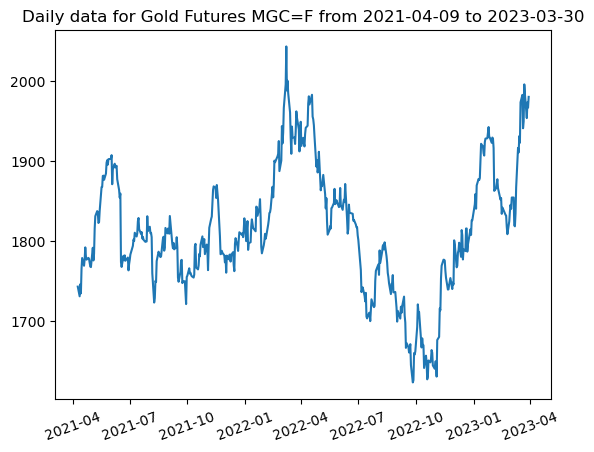

In [12]:
plt.plot(dates, X_raw)
plt.title(f"Daily data for Gold Futures MGC=F from {start_date} to {train_end_date}")
plt.xticks(rotation=20)
plt.show()

## Autocorrelation

Autocorrelation is a measure of the degree of similarity between a time series and a lagged version of itself. It quantifies the relationship between observations of a time series that are separated by a given time lag, and can be used to identify patterns and dependencies in the data. A time series with high autocorrelation implies that there is a strong relationship between adjacent observations, while a time series with low autocorrelation suggests that there is no significant relationship between adjacent observations.

Let's try to plot the autocorrelation function (acf) of the series: 

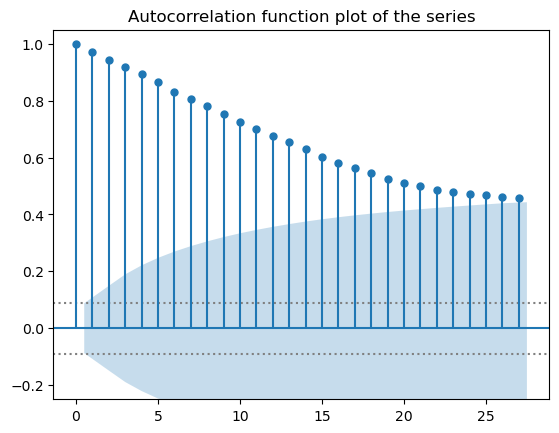

In [13]:
fig, ax = plt.subplots()

n = len(X_raw)
lower_signi_bound = -2 / np.sqrt(n)
upper_signi_bound = 2 / np.sqrt(n)

# Add the horizontal lines showing the significant bounds
ax.axhline(y=lower_signi_bound, linestyle=':', color='gray')
ax.axhline(y=upper_signi_bound, linestyle=':', color='gray')

plot_acf(X_raw, ax=ax)
plt.title("Autocorrelation function plot of the series")
plt.ylim(-0.25, 1.05)

plt.show()

The acf plot suggests that the acf decays slowlt, meaning that fitting an autoregressive (AR) process is plausible. 

## Partial Autocorrelation

Partial autocorrelation refers to the correlation between a time series variable and a lagged version of itself, after removing the linear dependence of this lagged version on all the intermediate lagged versions. In other words, it measures the correlation between a time series and its lagged version, after accounting for the correlation of the time series with all the intermediate lags between them. The partial autocorrelation function (PACF) is a tool used in time series analysis to identify the order of the autoregressive (AR) model, which helps in forecasting future values of the series.

Let's try to plot the pacf of our series obtained: 

/Users/adrianli375/miniconda3/envs/cpsc330/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


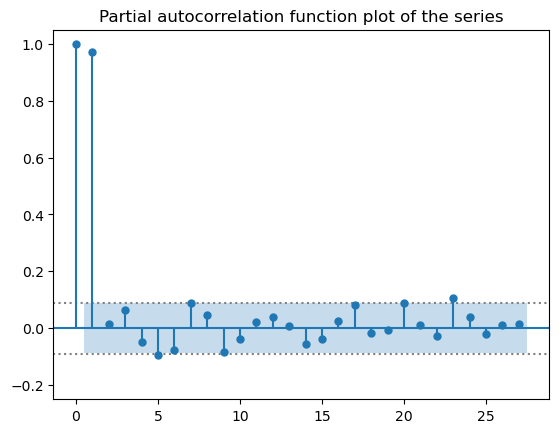

In [14]:
fig, ax = plt.subplots()

n = len(X_raw)
lower_signi_bound = -2 / np.sqrt(n)
upper_signi_bound = 2 / np.sqrt(n)

# Add the horizontal lines showing the significant bounds
ax.axhline(y=lower_signi_bound, linestyle=':', color='gray')
ax.axhline(y=upper_signi_bound, linestyle=':', color='gray')

plot_pacf(X_raw, ax=ax)
plt.title("Partial autocorrelation function plot of the series")
plt.ylim(-0.25, 1.05)

plt.show()

The PACF plot cuts off a lag 1, meaning that an $AR(1)$ process is suitable. 

## Fitted an AR(1) process to the data

In [16]:
arima = ARIMA(X_raw, order=(1, 0, 0))

In [17]:
model = arima.fit()

In [18]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  500
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2127.627
Date:                Sun, 09 Apr 2023   AIC                           4261.254
Time:                        22:41:48   BIC                           4273.897
Sample:                             0   HQIC                          4266.215
                                - 500                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1820.2121     34.287     53.087      0.000    1753.011    1887.414
ar.L1          0.9792      0.008    116.346      0.000       0.963       0.996
sigma2       288.9569     13.500     21.403      0.000     262.496     315.417
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                69.22
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               1.27   Skew:                            -0.25
Prob(H) (two-sided):                  0.13   Kurtosis:                         4.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Forecast our results

In [19]:
percent_ci = 0.95

In [20]:
forecast = model.get_forecast(steps=n_test)
ci = forecast.conf_int(alpha=1-percent_ci)

In [21]:
lower_bound = ci[:, 0]
upper_bound = ci[:, 1]

## Plot our results

In [23]:
test_dates = test_data.index

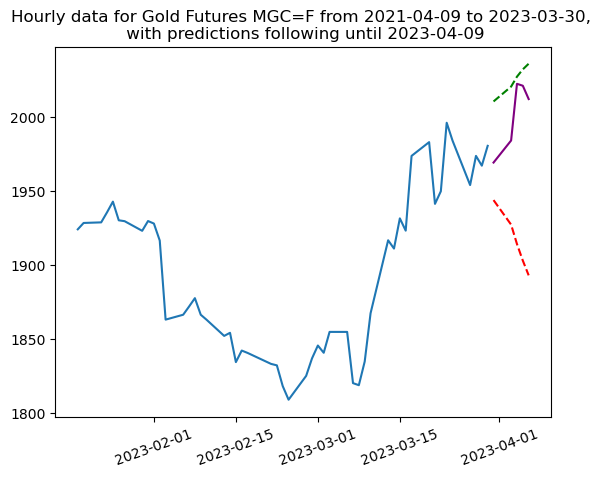

In [25]:
plt.plot(dates[-50:], X_raw[-50:]) # plot of training data
plt.plot(test_dates, test_data["Adj Close"].values, color="purple") # plot of test data
plt.plot(test_dates, lower_bound, linestyle="--", color="red") # plot of lower bound
plt.plot(test_dates, upper_bound, linestyle="--", color="green") # plot of upper bound

plot_start_date = dates[-1000:][0].strftime("%Y-%m-%d")

plt.title(f"Hourly data for Gold Futures MGC=F from {plot_start_date} to {train_end_date}, \n with predictions following until {end_date}")
plt.xticks(rotation=20)
plt.show()